# Global and Local Explanation for DNN model on PTB data
Input files:  
Mode: `model_ptb_dnn.pkl` generated in notebook `modeling_ptb_dnn.ipynb`     

Dataset: Binary classification datate genereted in notebook `preprocessing_ptb_standard_oversampling.ipynb`  
'ptb_train_clean_standard_oversampling.csv'  
'ptb_test_clean_standard_oversamling.csv'

In [1]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_path = data_path + 'model_ptb_dnn.h5' # pkl'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_path = '../models/' + 'model_ptb_dnn.h5' #pkl'


Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [2]:
# Verify installation and import libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
# import pickle
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adamax
import lime
import lime.lime_tabular


## load data

In [3]:
# Load
ptbdb_train = pd.read_csv(data_path + 'ptb_train_clean_standard_oversampling.csv')
ptbdb_test = pd.read_csv(data_path + 'ptb_test_clean_standard_oversampling.csv')

# Remove Dublicates
ptbdb_train = ptbdb_train.drop_duplicates()
ptbdb_test = ptbdb_test.drop_duplicates()

# Split data into features and target
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']
X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']


### load model

In [4]:
# Load and compile the model
try:
    loaded_model = load_model(model_path, compile=False)
except OSError as e:
    print(f"Error loading model: {e}")
    sys.exit("Check model path and try again.")

optimizer = Adamax(learning_rate=0.001)
loaded_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Evaluate the model
evaluation_metrics = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Model Evaluation - Loss: {evaluation_metrics[0]}, Accuracy: {evaluation_metrics[1]}, AUC: {evaluation_metrics[2]}")


Model Evaluation - Loss: 0.15917423367500305, Accuracy: 0.9429749250411987, AUC: 0.9838321208953857


In [5]:
# # Load the DNN model (wrapped inside a pipeline)
# with open(model_path, 'rb') as file:
#     pipeline_model = pickle.load(file)

# # Check the type of the model (pipeline)
# print(f"Model type: {type(pipeline_model)}")


### In the following we apply explanation strategies (Feature Importance, SHAP, LIME) on the raw PTB dataset to explain the most important features within the model due to to given strategies:


## Feature Importance

no Feature importance

## SHAP

In [6]:
import shap
# Prepare background data for SHAP and calculate SHAP values
background = X_train.sample(1000, random_state=42).values  # Sample background data for SHAP
X_test_array = X_test.values  # Convert X_test to a numpy array


In [7]:
# Initialize DeepExplainer with background data
explainer = shap.DeepExplainer(loaded_model, background)


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [8]:
# Compute SHAP values for each feature and sample
shap_values = explainer.shap_values(X_test_array)


In [9]:
# For binary classification, ensure we're using shap_values[0] (positive class)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Calculate mean absolute SHAP values across all test samples for each feature
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Verify that mean_shap_values is 1-dimensional
print("Shape of mean_shap_values before flattening:", mean_shap_values.shape)
if mean_shap_values.ndim > 1:
    mean_shap_values = mean_shap_values.flatten()  # Flatten if it's multi-dimensional
print("Shape of mean_shap_values after flattening:", mean_shap_values.shape)

# Verify the number of features matches
print("Number of features (X_test.columns):", len(X_test.columns))
print("Length of mean_shap_values:", len(mean_shap_values))

# Ensure lengths match before creating DataFrame
if len(mean_shap_values) == len(X_test.columns):
    # Create DataFrame for feature importance
    shap_importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': mean_shap_values
    })

    # Sort by importance and display top features
    shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)
    print("Top 10 most important features based on SHAP values:\n", shap_importance_df.head(10))
    


Shape of mean_shap_values before flattening: (187, 1)
Shape of mean_shap_values after flattening: (187,)
Number of features (X_test.columns): 187
Length of mean_shap_values: 187
Top 10 most important features based on SHAP values:
    feature  importance
2      c_2    0.053628
5      c_5    0.050515
6      c_6    0.048430
32    c_32    0.046123
7      c_7    0.043879
1      c_1    0.042568
29    c_29    0.031254
31    c_31    0.030850
4      c_4    0.029116
33    c_33    0.028387


C:\Users\Isabell Gurstein\AppData\Local\Temp\ipykernel_39556\338237840.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


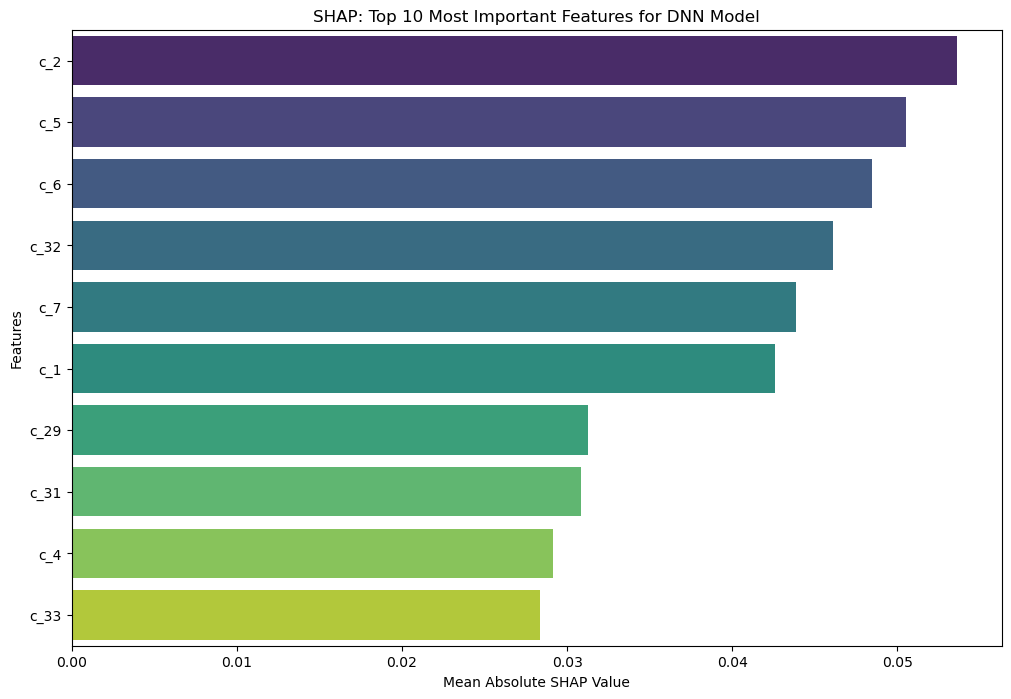

In [10]:
# Plot the top 10 most important features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='importance', 
    y='feature', 
    data=shap_importance_df.head(10), 
    palette='viridis'
)
plt.title('SHAP: Top 10 Most Important Features for DNN Model')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Features')
plt.show()



## LIME


True Label for selected instance: 0
Instance features:
 c_0     -2.078765
c_1     -1.507747
c_2     -1.261242
c_3     -0.496253
c_4     -0.455642
           ...   
c_182   -0.057988
c_183   -0.049427
c_184   -0.035082
c_185   -0.035330
c_186    0.000000
Name: 200, Length: 187, dtype: float64


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step


c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
c:\Users\Isabell Gurstein\anaconda3\envs\project_env\Lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

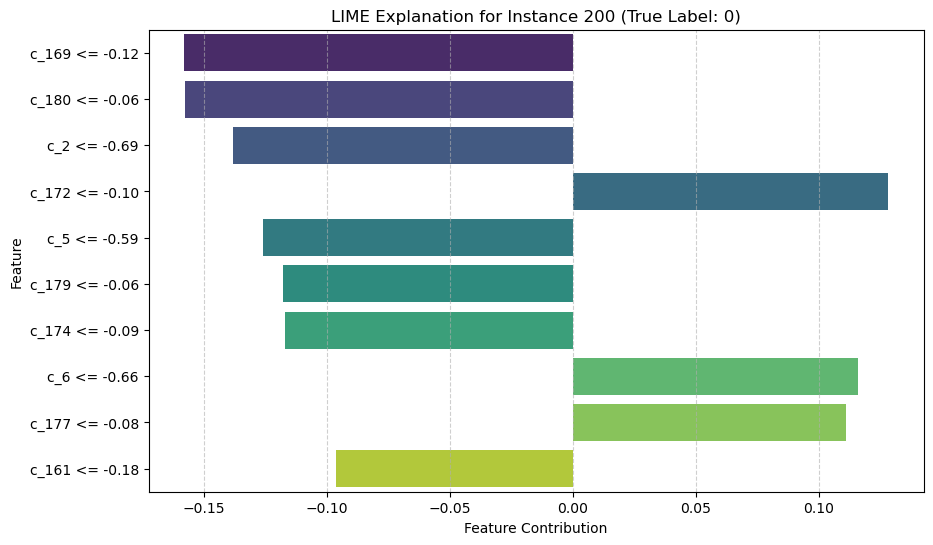

In [11]:
# Wrapper function for predict_proba behavior
def predict_proba_wrapper(data):
    # Predict using the model (outputs probabilities for binary classification)
    predictions = loaded_model.predict(data)
    # Reshape predictions to have two columns for binary classification: [1 - prediction, prediction]
    return np.column_stack([1 - predictions, predictions])

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' for binary classification
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification
    discretize_continuous=True  # Discretizes continuous features
)

# Select a random instance from the test set
idx = 200  # You can change this index to select a different instance
instance = X_test.iloc[idx]  # The input instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)

# Explain the instance using the LIME explainer
exp = explainer.explain_instance(
    data_row=instance,  # Instance to explain
    predict_fn=predict_proba_wrapper,  # Use the wrapper function here
    num_features=10  # Number of features to include in the explanation
)

# Extract feature contributions from the explanation object
feature_importance = exp.as_list()  # Returns a list of (feature, contribution) tuples

# Convert the feature importance to a DataFrame for easy visualization
lime_df = pd.DataFrame(feature_importance, columns=['Feature', 'Contribution'])

# Plot the LIME explanation using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Contribution', 
    y='Feature', 
    data=lime_df, 
    palette='viridis', 
    orient='h'
)
plt.title(f'LIME Explanation for Instance {idx} (True Label: {true_label})')
plt.xlabel('Feature Contribution')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()



In [12]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-11-13 11:44:46.487263
